In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from simpegtorch.discretize import TensorMesh
from simpegtorch.simulation.resistivity import (
    DC3DCellCentered,
    SrcDipole,
    RxDipole,
    Survey,
)
from simpegtorch.simulation.base import DirectSolver, mappings
from simpegtorch.inversion import (
    BaseInversion,
    BaseInvProblem,
    BetaSchedule,
    TargetMisfit,
    BetaEstimate_ByEig,
)
from simpegtorch.data_misfit import L2DataMisfit
from simpegtorch.regularization import WeightedLeastSquares

from simpegtorch.utils import (
    get_indices_sphere,
    active_from_xyz
)

from simpegtorch.simulation.utils import (
    pseudo_locations,
    generate_dcip_sources_line,
    
)

# Set default dtype
torch.set_default_dtype(torch.float64)


In [2]:
# Generate some topography, taking this from simpeg examples 
x_topo, y_topo = np.meshgrid(
    np.linspace(-2100, 2100, 141), np.linspace(-2100, 2100, 141)
)
z_topo = 410.0 + 100.0 * (1 / np.pi) * (
    np.arctan((x_topo - 500 * np.sin(np.pi * y_topo / 2800) - 400.0) / 200.0)
    - np.arctan((x_topo - 500 * np.sin(np.pi * y_topo / 2800) + 400.0) / 200.0)
)

topo_xyz = torch.cat([
    torch.tensor(x_topo).flatten().unsqueeze(1),
    torch.tensor(y_topo).flatten().unsqueeze(1),
    torch.tensor(z_topo).flatten().unsqueeze(1) 
], dim=1)

topo_xyz.shape

torch.Size([19881, 3])

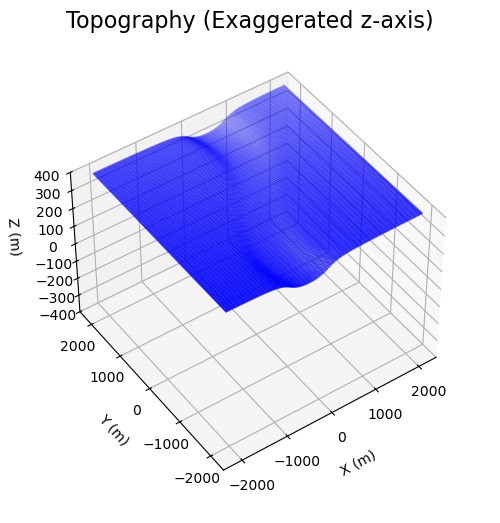

In [3]:
# Plot the topography
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection="3d")
ax.set_zlim([-400, 400])
ax.scatter3D(topo_xyz[:, 0], topo_xyz[:, 1], topo_xyz[:, 2], s=0.25, c="b")
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.set_xlabel("X (m)", labelpad=10)
ax.set_ylabel("Y (m)", labelpad=10)
ax.set_zlabel("Z (m)", labelpad=10)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=-20)
ax.view_init(elev=45.0, azim=-125)

In [4]:
# Define the parameters for each survey line
survey_type = "dipole-dipole"
data_type = "volt"
dimension_type = "3D"
end_locations_list = [
    np.r_[-1000.0, 1000.0, 0.0, 0.0],
    np.r_[-600.0, -600.0, -1000.0, 1000.0],
    np.r_[-300.0, -300.0, -1000.0, 1000.0],
    np.r_[0.0, 0.0, -1000.0, 1000.0],
    np.r_[300.0, 300.0, -1000.0, 1000.0],
    np.r_[600.0, 600.0, -1000.0, 1000.0],
]  # [x0, x1, y0, y1]
station_separation = 25.0
num_rx_per_src = 31

# The source lists for each line can be appended to create the source
# list for the whole survey.
source_list = []
for ii in range(0, len(end_locations_list)):
    source_list += generate_dcip_sources_line(
        survey_type,
        data_type,
        dimension_type,
        end_locations_list[ii],
        topo_xyz,
        num_rx_per_src,
        station_separation,
    )

# Define the survey
survey = Survey(source_list)

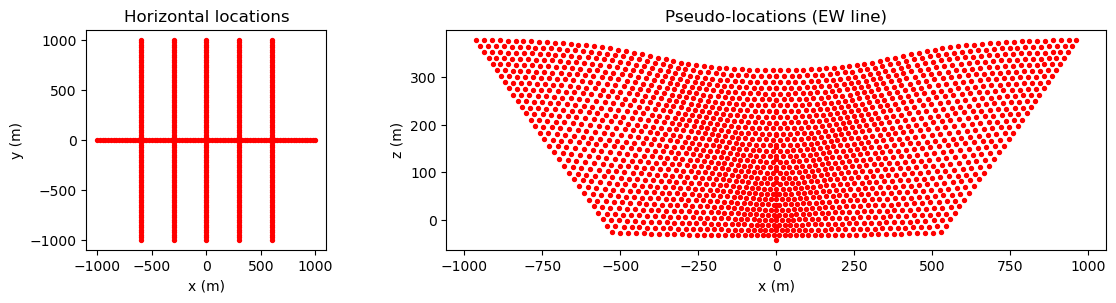

In [5]:
unique_locations = survey.unique_electrode_locations
fig = plt.figure(figsize=(12, 2.75))
ax1 = fig.add_axes([0.1, 0.1, 0.2, 0.8])
ax1.scatter(unique_locations[:, 0], unique_locations[:, 1], 8, "r")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")
ax1.set_title("Horizontal locations")

pseudo_locations_xyz = pseudo_locations(survey)
inds = pseudo_locations_xyz[:, 1] == 0.0
ax2 = fig.add_axes([0.4, 0.1, 0.55, 0.8])
ax2.scatter(pseudo_locations_xyz[inds, 0], pseudo_locations_xyz[inds, -1], 8, "r")
ax2.set_xlabel("x (m)")
ax2.set_ylabel("z (m)")
ax2.set_title("Pseudo-locations (EW line)")
plt.show()

In [6]:
# Defining domain size and minimum cell size
dh = 50.0  # base cell width
dom_width_x = 2100.0  # domain width x
dom_width_y = 2100.0  # domain width y
dom_width_z = 500.0  # domain width z

# Number of base mesh cells in each direction
nbcx = int(dom_width_x / dh)  # num. base cells x
nbcy = int(dom_width_y / dh)  # num. base cells y
nbcz = int(dom_width_z / dh)  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hy = [(dh, nbcy)]
hz = [(dh, nbcz)]
mesh = TensorMesh([hx, hy, hz], origin="CCN")

# Shift top to maximum topography
mesh.origin = mesh.origin + torch.tensor([0.0, 0.0, z_topo.max()])

In [7]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_xyz)
n_active = torch.sum(active_cells)
n_total = mesh.nC


Surface elevation range: 339.52 to 409.23 m (mean: 392.28 m)
Found 16766 active cells out of 17640 total cells


In [8]:
# Define conductivity values in S/m (take reciprocal for resistivities in Ohm m)
air_conductivity = 1e-8
background_conductivity = 1e-2
conductor_conductivity = 1e-1
resistor_conductivity = 1e-3

# Define conductivity model
conductivity_model = background_conductivity * np.ones(n_total)

ind_conductor = get_indices_sphere(
    np.r_[-300.0, 0.0, 300.0], 100.0, mesh.cell_centers
)

ind_resistor = get_indices_sphere(
    np.r_[300.0, 0.0, 300.0], 100.0, mesh.cell_centers
)

conductivity_model[ind_conductor] = conductor_conductivity
conductivity_model[ind_resistor] = resistor_conductivity
conductivity_model[~active_cells] = air_conductivity



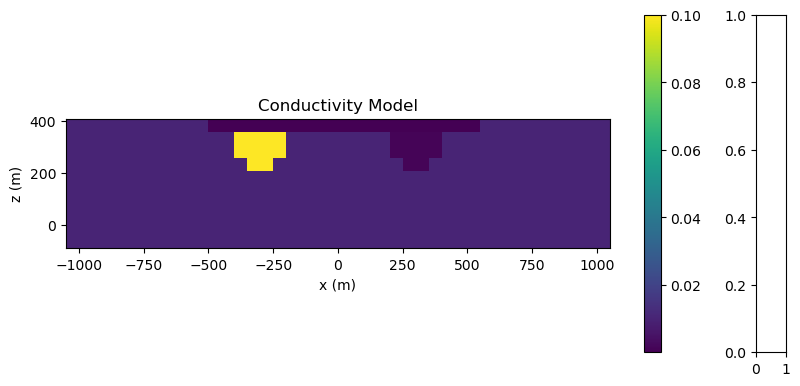

In [9]:
# Generate a mapping to ignore inactive cells in plot

fig = plt.figure(figsize=(10, 4.5))

ax1 = fig.add_axes([0.15, 0.15, 0.68, 0.75])
mesh.plot_slice(
    conductivity_model,
    ax=ax1,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    grid=True,
)
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax1.set_ylim([mesh.origin[2], mesh.origin[2] + mesh.h[2].sum()])  # Adjust y-limits based on mesh

ax2 = fig.add_axes([0.84, 0.15, 0.03, 0.75])


In [10]:
# Create mapping and PDE for forward modeling
sigma_true = mappings.BaseMapping(ground_parameters=torch.tensor(conductivity_model), active_cells=active_cells)
pde_true = DC3DCellCentered(mesh, survey, sigma_true, bc_type="Dirichlet")
solver_true = DirectSolver(pde_true)

Homogeneous Dirichlet is the natural BC for this CC discretization


/Users/tsuchijo/Documents/GIF_Work/simpeg-torch/simpegtorch/discretize/operators/differential_operators.py:308: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1746257065223/work/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  sdiag(1 / V, device=self.device, dtype=self.dtype)


In [11]:
# Generate clean data
torch.set_default_dtype(torch.float64)

with torch.no_grad():
    data_clean = solver_true.forward()


noise_std = 0.05 * torch.abs(data_clean)
noise = torch.normal(0.0, noise_std)
data_noisy = data_clean + noise
uncertainties = noise_std + 1e-6



In [12]:
# Setup the solver we will invert over
sigma_start = torch.ones(mesh.n_cells) *  1e-2
sigma_start[~active_cells] = air_conductivity
sigma_map_start = mappings.BaseMapping(sigma_start, active_cells=active_cells)
pde_start = DC3DCellCentered(mesh, survey, sigma_map_start, bc_type="Dirichlet")
solver_start = DirectSolver(pde_start)


Homogeneous Dirichlet is the natural BC for this CC discretization


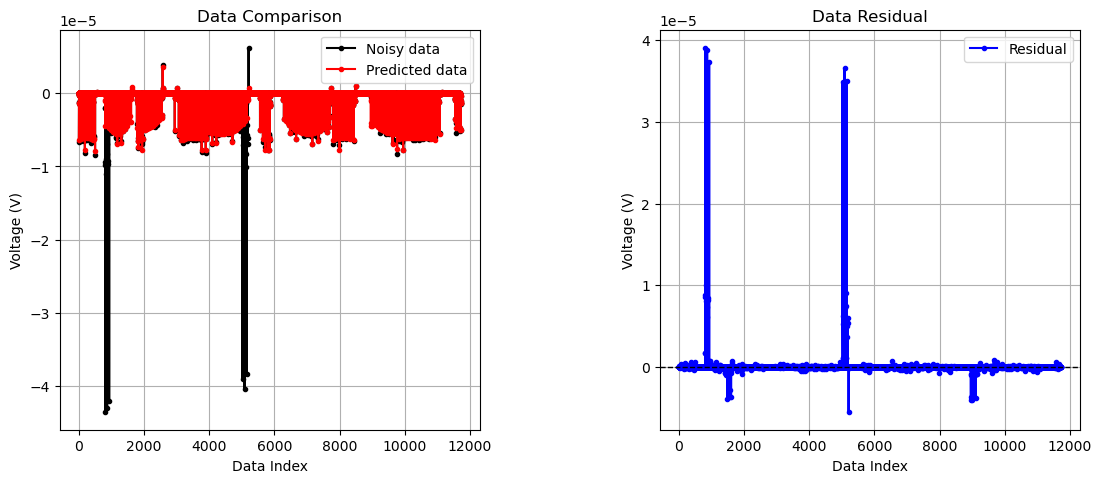

In [13]:
## plot the data initially for prior model
with torch.no_grad():
    data_start = solver_start.forward()
    residual_start = data_start - data_noisy
# make 2 plots, one with the data and the other with the residual
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.35, 0.8])
ax1.plot(data_noisy.numpy(), "k.-", label="Noisy data")
ax1.plot(data_start.numpy(), "r.-", label="Predicted data")
ax1.set_xlabel("Data Index")
ax1.set_ylabel("Voltage (V)")
ax1.set_title("Data Comparison")
ax1.legend()
ax1.grid()
ax2 = fig.add_axes([0.6, 0.1, 0.35, 0.8])
ax2.plot(residual_start.numpy(), "b.-", label="Residual")
ax2.axhline(0.0, color="k", linestyle="--", linewidth=1)
ax2.set_xlabel("Data Index")
ax2.set_ylabel("Voltage (V)")
ax2.set_title("Data Residual")
ax2.legend()
ax2.grid()
plt.show()



In [14]:
# Setup inversion objectives and directives
data_misfit = L2DataMisfit(solver_start, data_noisy, 1/uncertainties)
reg_small = WeightedLeastSquares(
    mesh,
    mapping=sigma_map_start,
    alpha_s=1.0,
    alpha_x=0.01,
    alpha_y=0.01,
    alpha_z=0.01,
)

optimizer = torch.optim.LBFGS(
    [sigma_map_start.trainable_parameters],
    max_iter=20,
    lr=1.0,
    line_search_fn="strong_wolfe",
)


inv_prob = BaseInvProblem(
    data_misfit, reg_small, optimizer, beta=1.0, max_iter=20
)

directives = [
    BetaEstimate_ByEig(),
    BetaSchedule(cooling_factor=2, cooling_rate=2.0),
    #TargetMisfit(chi_factor=1.0),
]

inversion = BaseInversion(inv_prob, directives)

In [15]:
sigma_recovered = inversion.run()

BetaEstimate: β set to 7.61e-03 (ratio = 1.0)
Running inversion with 2 directives
Device: cpu, dtype: torch.float64
Iter   0: φ = 3.19e+03 (φ_d = 1.59e+03, β×φ_m = 1.59e+03) 
Iter   1: φ = 2.82e+03 (φ_d = 1.24e+03, β×φ_m = 1.58e+03) 
BetaSchedule: β reduced from 7.61e-03 to 3.80e-03
Iter   2: φ = 1.93e+03 (φ_d = 1.14e+03, β×φ_m = 7.90e+02) 
Iter   3: φ = 1.86e+03 (φ_d = 1.08e+03, β×φ_m = 7.86e+02) 
BetaSchedule: β reduced from 3.80e-03 to 1.90e-03
Iter   4: φ = 9.37e+02 (φ_d = 5.50e+02, β×φ_m = 3.87e+02) 
Iter   5: φ = 9.16e+02 (φ_d = 5.29e+02, β×φ_m = 3.87e+02) 
BetaSchedule: β reduced from 1.90e-03 to 9.51e-04
Iter   6: φ = 6.81e+02 (φ_d = 4.88e+02, β×φ_m = 1.94e+02) 
Iter   7: φ = 6.60e+02 (φ_d = 4.66e+02, β×φ_m = 1.94e+02) 
BetaSchedule: β reduced from 9.51e-04 to 4.76e-04
Iter   8: φ = 5.44e+02 (φ_d = 4.47e+02, β×φ_m = 9.69e+01) 
Iter   9: φ = 5.35e+02 (φ_d = 4.38e+02, β×φ_m = 9.69e+01) 
BetaSchedule: β reduced from 4.76e-04 to 2.38e-04
Iter  10: φ = 4.86e+02 (φ_d = 4.37e+02, β×φ_

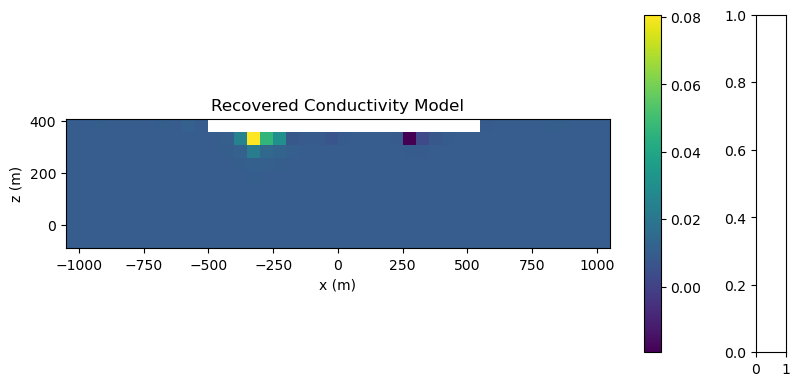

In [16]:
## plot the recovered model
fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_axes([0.15, 0.15, 0.68, 0.75])
sigma_plotting = sigma_recovered.forward().detach().numpy()
sigma_plotting[~active_cells] = np.nan
mesh.plot_slice(
    sigma_plotting,
    ax=ax1,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    grid=True,
)
ax1.set_title("Recovered Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax1.set_ylim([mesh.origin[2], mesh.origin[2] + mesh.h[2].sum()])  # Adjust y-limits based on mesh
ax2 = fig.add_axes([0.84, 0.15, 0.03, 0.75])
plt.show()


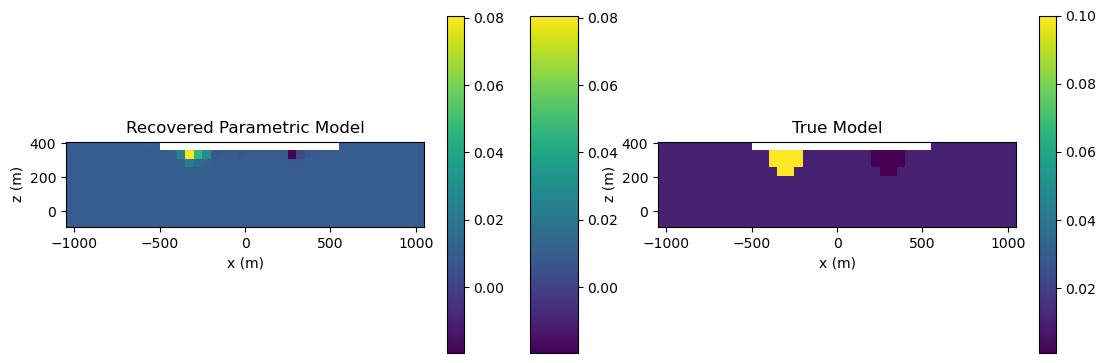


Learned parameters:


OverflowError: (34, 'Result too large')

In [30]:
## Plot the recovered parametric model
fig = plt.figure(figsize=(16, 4.5))

# Recovered model
ax1 = fig.add_axes([0.05, 0.15, 0.28, 0.75])
sigma_plotting = sigma_recovered.forward().detach().numpy()
sigma_plotting[~active_cells] = np.nan
mesh.plot_slice(
    sigma_plotting,
    ax=ax1,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    grid=True,
)
ax1.set_title("Recovered Parametric Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax1.set_ylim([mesh.origin[2], mesh.origin[2] + mesh.h[2].sum()])
# set the heat map color bar to be the same for all plots
ax2 = fig.add_axes([0.34, 0.15, 0.03, 0.75])
plt.colorbar(ax1.get_children()[0], cax=ax2)



# True model for comparison
ax3 = fig.add_axes([0.42, 0.15, 0.28, 0.75])
sigma_true_plot = conductivity_model.copy()
sigma_true_plot[~active_cells] = np.nan
mesh.plot_slice(
    sigma_true_plot,
    ax=ax3,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    grid=True,
)
ax3.set_title("True Model")
ax3.set_xlabel("x (m)")
ax3.set_ylabel("z (m)")
ax3.set_ylim([mesh.origin[2], mesh.origin[2] + mesh.h[2].sum()])


plt.show()


Homogeneous Dirichlet is the natural BC for this CC discretization


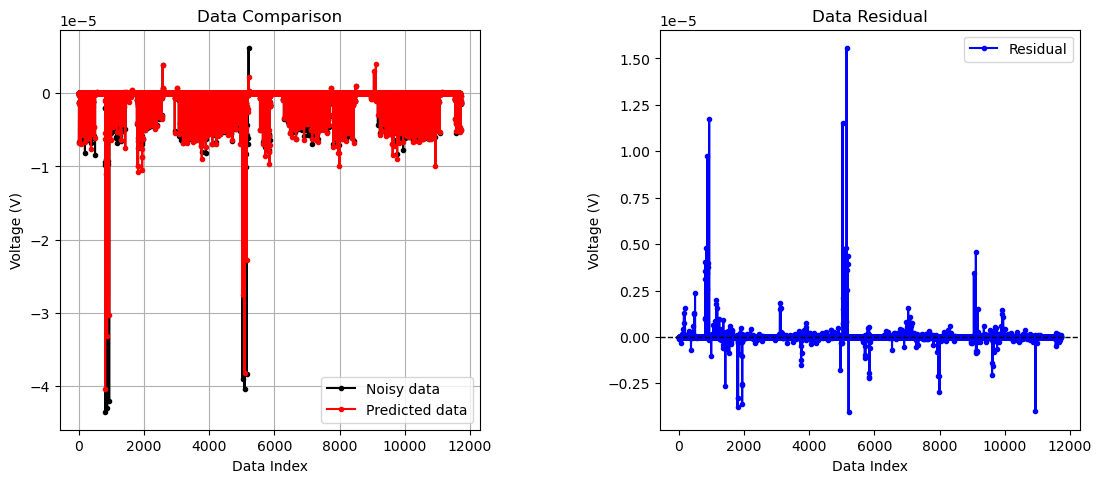

In [17]:
## Plot the residuals
with torch.no_grad():
    pde_recovered = DC3DCellCentered(mesh, survey, sigma_recovered, bc_type="Dirichlet")
    solver_recovered = DirectSolver(pde_recovered)
    data_recovered = solver_recovered.forward()
    residual_recovered = data_recovered - data_noisy
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.35, 0.8])
ax1.plot(data_noisy.numpy(), "k.-", label="Noisy data")
ax1.plot(data_recovered.numpy(), "r.-", label="Predicted data")
ax1.set_xlabel("Data Index")
ax1.set_ylabel("Voltage (V)")
ax1.set_title("Data Comparison")
ax1.legend()
ax1.grid()
ax2 = fig.add_axes([0.6, 0.1, 0.35, 0.8])
ax2.plot(residual_recovered.numpy(), "b.-", label="Residual")
ax2.axhline(0.0, color="k", linestyle="--", linewidth=1)
ax2.set_xlabel("Data Index")

ax2.set_ylabel("Voltage (V)")
ax2.set_title("Data Residual")
ax2.legend()

In [31]:
## Create an improved parametric mapping with fixed grid of Gaussians
from simpegtorch.simulation.base.mappings import BaseMapping

class LogInverseMapping(BaseMapping):
    """
    Log-inverse mapping class for parameter transformations in simpeg-torch.

    This class extends BaseMapping to implement a log-inverse transformation,
    such as mapping from log-resistivity to conductivity.
    """

    def __init__(
        self, ground_parameters: torch.Tensor, active_cells: torch.Tensor = None
    ):
        super().__init__(ground_parameters, active_cells)

    def forward(self):
        """
        Apply the logarithmic transformation to the full parameter tensor.

        Returns
        -------
        torch.Tensor
            Transformed model parameters tensor
        """
        full_params = self.get_full_parameters()
        return 1 / torch.exp(full_params)

In [35]:
# Initialize the parametric mapping with fixed grid of Gaussians
log_rho_map = LogInverseMapping(
    ground_parameters=torch.log(1/torch.tensor(sigma_start)),
    active_cells=active_cells,
)

# Setup PDE and solver with parametric mapping
pde = DC3DCellCentered(mesh, survey, log_rho_map, bc_type="Dirichlet")
solver = DirectSolver(pde)

# Visualize initial parametric model
with torch.no_grad():
    sigma_initial = log_rho_map.forward()



Homogeneous Dirichlet is the natural BC for this CC discretization


/var/folders/6s/vwxlnc5s1ts9k7hbcs0kj4jh0000gn/T/ipykernel_64106/2990420589.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_parameters=torch.log(1/torch.tensor(sigma_start)),


In [48]:
# Setup inversion with parametric model
data_misfit = L2DataMisfit(solver, data_noisy, 1/uncertainties)

# Small regularization on the RBF amplitudes to prevent extreme values
reg = WeightedLeastSquares(
    mesh,
    mapping=log_rho_map,
    alpha_s=1.0,  # Small smoothness regularization on amplitudes
    alpha_x=0.1,
    alpha_y=0.1,
    alpha_z=0.1,
    alpha_xx=0.0,
    alpha_yy=0.0,
    alpha_zz=0.0,
)

# Use Adam optimizer with learning rate scheduling
optimizer = torch.optim.LBFGS(
    [log_rho_map.trainable_parameters],
    max_iter=20,
    lr=1.0,
    line_search_fn="strong_wolfe",
)

inv_prob_log = BaseInvProblem(
    data_misfit, 
    reg, 
    optimizer, 
    beta=1.0, 
    max_iter=10
)


directives = [
    BetaEstimate_ByEig(),
    BetaSchedule(cooling_factor=2, cooling_rate=2.0),
    #TargetMisfit(chi_factor=1.0),
]

inversion = BaseInversion(inv_prob_log, directives)

In [49]:
sigma_recovered = inversion.run()

BetaEstimate: β set to 1.86e-02 (ratio = 1.0)
Running inversion with 2 directives
Device: cpu, dtype: torch.float64
Iter   0: φ = 1.09e+03 (φ_d = 5.43e+02, β×φ_m = 5.43e+02) 
Iter   1: φ = 9.56e+02 (φ_d = 3.86e+02, β×φ_m = 5.71e+02) 
BetaSchedule: β reduced from 1.86e-02 to 9.30e-03
Iter   2: φ = 6.52e+02 (φ_d = 3.95e+02, β×φ_m = 2.57e+02) 
Iter   3: φ = 6.00e+02 (φ_d = 3.23e+02, β×φ_m = 2.77e+02) 
BetaSchedule: β reduced from 9.30e-03 to 4.65e-03
Iter   4: φ = 4.44e+02 (φ_d = 3.15e+02, β×φ_m = 1.29e+02) 
Iter   5: φ = 4.09e+02 (φ_d = 2.70e+02, β×φ_m = 1.39e+02) 
BetaSchedule: β reduced from 4.65e-03 to 2.33e-03
Iter   6: φ = 3.26e+02 (φ_d = 2.60e+02, β×φ_m = 6.61e+01) 
Iter   7: φ = 3.04e+02 (φ_d = 2.34e+02, β×φ_m = 7.02e+01) 
BetaSchedule: β reduced from 2.33e-03 to 1.16e-03
Iter   8: φ = 2.56e+02 (φ_d = 2.22e+02, β×φ_m = 3.38e+01) 
Iter   9: φ = 2.40e+02 (φ_d = 2.04e+02, β×φ_m = 3.57e+01) 
BetaSchedule: β reduced from 1.16e-03 to 5.81e-04
Inversion completed after 10 iterations


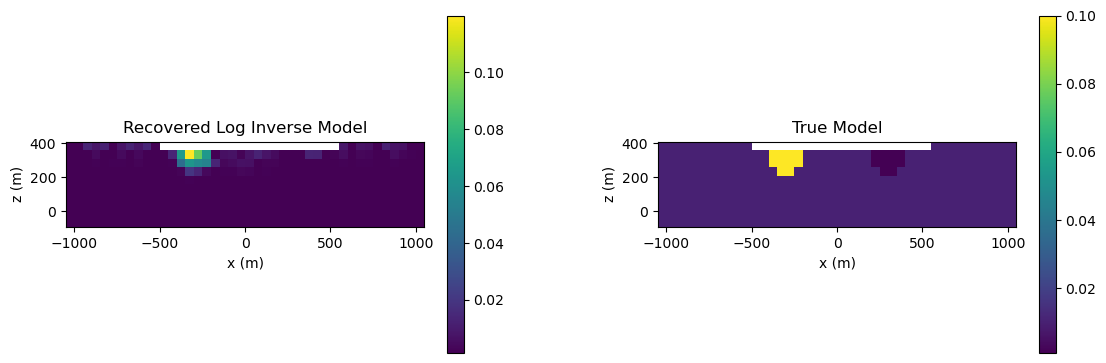

In [50]:
## Plot the recovered parametric model
fig = plt.figure(figsize=(16, 4.5))

# Recovered model
ax1 = fig.add_axes([0.05, 0.15, 0.28, 0.75])
sigma_plotting = log_rho_map.forward().detach().numpy()
sigma_plotting[~active_cells] = np.nan
mesh.plot_slice(
    sigma_plotting,
    ax=ax1,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    grid=True,
)
ax1.set_title("Recovered Log Inverse Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax1.set_ylim([mesh.origin[2], mesh.origin[2] + mesh.h[2].sum()])

# True model for comparison
ax3 = fig.add_axes([0.42, 0.15, 0.28, 0.75])
sigma_true_plot = conductivity_model.copy()
sigma_true_plot[~active_cells] = np.nan
mesh.plot_slice(
    sigma_true_plot,
    ax=ax3,
    normal="Y",
    ind=int(len(mesh.h[1]) / 2),
    grid=True,
)
ax3.set_title("True Model")
ax3.set_xlabel("x (m)")
ax3.set_ylabel("z (m)")
ax3.set_ylim([mesh.origin[2], mesh.origin[2] + mesh.h[2].sum()])


plt.show()
